# Load Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import math
import pandas as pd
import os
import numpy as np

In [113]:
ner_df = pd.read_csv('/Users/dima/Downloads/entity-annotated-corpus (1)/ner_dataset.csv')
#ner_df['Word'] = ner_df['Word'].str.lower()

In [114]:
ner_df.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [4]:
sentences_words = []
sentences_tags = []
curr_sent_num = -1
current_sentence_words = []
current_sentence_tags = []
for sent_num, word, tag in ner_df[['Sentence #', 'Word', 'Tag']].values:   
    if isinstance(sent_num, basestring) and 'Sentence: ' in sent_num:
        curr_sent_num = int(sent_num.split(':')[1].strip())
        
        if current_sentence_words and current_sentence_tags:
            sentences_words.append(current_sentence_words)
            sentences_tags.append(current_sentence_tags)
            
        current_sentence_words = []
        current_sentence_tags = []
        
    current_sentence_words.append(word.decode(errors='replace'))
    current_sentence_tags.append(tag)

len(sentences_words), len(sentences_tags)

(47958, 47958)

In [5]:
for w, k in zip(sentences_words[123], sentences_tags[123]): print w, k


not O
counting O
the O
latest O
death O
, O
the O
world B-org
health I-org
organization I-org
says O
227 O
people O
around O
the O
world O
have O
died O
from O
bird O
flu O
since O
2003 B-tim
. O


In [6]:
train_size = int(len(sentences_words) * 0.8)

train_sentences_words = sentences_words[:train_size]
train_sentences_tags = sentences_tags[:train_size]
test_sentences_words = sentences_words[train_size:]
test_sentences_tags = sentences_tags[train_size:]

print 'Train:', len(train_sentences_words), len(train_sentences_tags)
print 'Test:', len(test_sentences_words), len(test_sentences_tags)

Train: 38366 38366
Test: 9592 9592


# BoW + Cls Benchmark

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import scipy

In [8]:
def sentence_to_instances(words, tags, bow, count_vectorizer):
    X = []
    y = []
    for w, t in zip(words, tags):
        v = count_vectorizer.transform([w])[0]
        v = scipy.sparse.hstack([v, bow])
        X.append(v)
        y.append(t)
        
    return scipy.sparse.vstack(X), y

def sentences_to_instances(sentences_words, sentences_tags, count_vectorizer):
    bows = count_vectorizer.transform(map(lambda s: ' '.join(s), sentences_words))
    X = []
    y = []
    for words, tags, bow in zip(sentences_words, sentences_tags, bows):
        sent_X, sent_y = sentence_to_instances(words, tags, bow, count_vectorizer)
        X.append(sent_X)
        y += sent_y
        
    return scipy.sparse.vstack(X), np.array(y)

In [9]:
count_vectorizer = CountVectorizer().fit(map(lambda s: ' '.join(s), train_sentences_words))

In [10]:
train_X, train_y = sentences_to_instances(train_sentences_words, train_sentences_tags, count_vectorizer)
train_X.shape, train_y.shape

((839214, 50892), (839214,))

In [11]:
test_X, test_y = sentences_to_instances(test_sentences_words, test_sentences_tags, count_vectorizer)
test_X.shape, test_y.shape

((209353, 50892), (209353,))

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

/Users/dima/.virtualenvs/hs/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [13]:
clf = GradientBoostingClassifier().fit(train_X, train_y)

In [14]:
predicted = clf.predict(test_X)

In [15]:
print classification_report(test_y, predicted)

             precision    recall  f1-score   support

      B-art       0.57      0.05      0.09        82
      B-eve       0.68      0.28      0.40        46
      B-geo       0.91      0.40      0.56      7553
      B-gpe       0.96      0.84      0.90      3242
      B-nat       0.52      0.27      0.36        48
      B-org       0.93      0.31      0.46      4082
      B-per       0.80      0.52      0.63      3321
      B-tim       0.91      0.66      0.76      4107
      I-art       0.09      0.02      0.04        43
      I-eve       0.33      0.02      0.04        44
      I-geo       0.82      0.55      0.66      1408
      I-gpe       0.86      0.62      0.72        40
      I-nat       0.20      0.08      0.12        12
      I-org       0.88      0.24      0.38      3470
      I-per       0.93      0.25      0.40      3332
      I-tim       0.67      0.15      0.25      1308
          O       0.91      1.00      0.95    177215

avg / total       0.91      0.91      0.89  

# Prepare for Seq2Seq

In [16]:
vocab = set(itertools.chain(*[[w for w in s] for s in train_sentences_words])) 
tags = set(itertools.chain(*[[w for w in s] for s in train_sentences_tags]))
sentenecs_lens = map(len, train_sentences_words)
len(vocab), len(tags), len(sentenecs_lens)

(28822, 17, 38366)

(array([3.5510e+03, 1.5670e+04, 1.4854e+04, 3.8890e+03, 3.3800e+02,
        5.2000e+01, 1.0000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  11.3,  21.6,  31.9,  42.2,  52.5,  62.8,  73.1,  83.4,
         93.7, 104. ]),
 <a list of 10 Patch objects>)

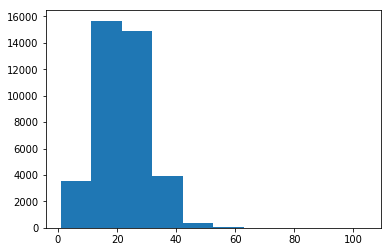

In [17]:
plt.hist(sentenecs_lens)

In [18]:
MAX_LEN = 75#max(sentenecs_lens)
VOCAB_SIZE = len(vocab)

In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/Users/dima/.virtualenvs/hs/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
words_tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters=[], oov_token='__UNKNOWN__')
words_tokenizer.fit_on_texts(map(lambda s: ' '.join(s), train_sentences_words))
word_index = words_tokenizer.word_index
word_index['__PADDING__'] = 0
index_word = {i:w for w, i in word_index.iteritems()}
print 'Unique tokens:', len(word_index)

Unique tokens: 28824


In [21]:
train_sequences = words_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), train_sentences_words))
test_sequences = words_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), test_sentences_words))


In [22]:
train_sequences_padded = pad_sequences(train_sequences, maxlen=MAX_LEN)
test_sequences_padded = pad_sequences(test_sequences, maxlen=MAX_LEN)

print train_sequences_padded.shape, test_sequences_padded.shape

(38366, 75) (9592, 75)


In [23]:
tags_tokenizer = Tokenizer(num_words=len(tags), filters='', oov_token='__UNKNOWN__', lower=False)
tags_tokenizer.fit_on_texts(map(lambda s: ' '.join(s), train_sentences_tags))
tag_index = tags_tokenizer.word_index
tag_index['__PADDING__'] = 0
index_tag = {i:w for w, i in tag_index.iteritems()}

index_tag_wo_padding = dict(index_tag)
index_tag_wo_padding[tag_index['__PADDING__']] = '0'
print 'Unique tags:', len(tag_index)

Unique tags: 19


In [24]:
train_tags = tags_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), train_sentences_tags))
test_tags = tags_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), test_sentences_tags))


In [77]:
train_tags_padded = pad_sequences(train_tags, maxlen=MAX_LEN)
test_tags_padded = pad_sequences(test_tags, maxlen=MAX_LEN)

train_tags_padded = np.expand_dims(train_tags_padded, -1)
test_tags_padded = np.expand_dims(test_tags_padded, -1)
print train_tags_padded.shape, test_tags_padded.shape

(38366, 75, 1) (9592, 75, 1)


In [26]:
for w, t in zip(train_sequences_padded[123], train_tags_padded[123]):
    print index_word[w], index_tag[t[0]]

__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PA

# Bi-LSTM 

In [27]:
from keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout
from keras.models import Model
from keras.initializers import Constant

In [28]:
random_embedding_layer = Embedding(VOCAB_SIZE,
                                300,
                                input_length=MAX_LEN)

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = random_embedding_layer(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
preds = Dense(len(tag_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['sparse_categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 300)           8646600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 128)           186880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 128)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 75, 32)            4128      
_________________________________________________________________
dense_2 (Dense)              (None, 75, 19)            627       
Total params: 8,838,235
Trainable params: 8,838,235
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(train_sequences_padded, train_tags_padded,
          batch_size=32,
          epochs=10,
          validation_data=(test_sequences_padded, test_tags_padded))

Train on 38366 samples, validate on 9592 samples
Epoch 1/10
38366/38366 [==============================] - 274s 7ms/step - loss: 0.1307 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.0465 - val_sparse_categorical_accuracy: 0.9869
Epoch 2/10
38366/38366 [==============================] - 276s 7ms/step - loss: 0.0365 - sparse_categorical_accuracy: 0.9892 - val_loss: 0.0438 - val_sparse_categorical_accuracy: 0.9879
Epoch 3/10
38366/38366 [==============================] - 264s 7ms/step - loss: 0.0280 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.0470 - val_sparse_categorical_accuracy: 0.9880
Epoch 4/10
38366/38366 [==============================] - 261s 7ms/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9928 - val_loss: 0.0480 - val_sparse_categorical_accuracy: 0.9878
Epoch 5/10
38366/38366 [==============================] - 263s 7ms/step - loss: 0.0189 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.0531 - val_sparse_categorical_accuracy: 0.9878
Epoch 6/10
38366/3836

# Evaluation

In [30]:
from seqeval.metrics import classification_report, f1_score

In [31]:
lstm_predicted = model.predict(test_sequences_padded)

In [32]:
lstm_predicted_tags = []
bow_predicted_tags = []
for s, s_pred in zip(test_sentences_words, lstm_predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = map(index_tag_wo_padding.get,tags)[-len(s):]
    lstm_predicted_tags.append(tags)
    
    bow_vector, _ = sentences_to_instances([s], [['x']*len(s)], count_vectorizer)
    bow_predicted = clf.predict(bow_vector)[0]
    bow_predicted_tags.append(bow_predicted)
    

In [33]:
print 'LSTM'
print '='*15
print classification_report(test_sentences_tags, lstm_predicted_tags)
print 
print 'BOW'
print '='*15
print classification_report(test_sentences_tags, bow_predicted_tags)

LSTM
             precision    recall  f1-score   support

        art       0.11      0.10      0.10        82
        gpe       0.94      0.96      0.95      3242
        eve       0.21      0.33      0.26        46
        per       0.66      0.58      0.62      3321
        tim       0.84      0.83      0.84      4107
        nat       0.00      0.00      0.00        48
        org       0.58      0.55      0.57      4082
        geo       0.83      0.83      0.83      7553

avg / total       0.77      0.75      0.76     22481


BOW
             precision    recall  f1-score   support

        art       0.00      0.00      0.00        82
        gpe       0.01      0.00      0.00      3242
        eve       0.00      0.00      0.00        46
        per       0.00      0.00      0.00      3321
        tim       0.00      0.00      0.00      4107
        nat       0.00      0.00      0.00        48
        org       0.01      0.00      0.00      4082
        geo       0.03      0.00

In [34]:
print 'LSTM:', f1_score(test_sentences_tags, lstm_predicted_tags)
print 'BOW:', f1_score(test_sentences_tags, bow_predicted_tags)

LSTM: 0.764890423635
BOW: 0.00173632642937


# Pre Trained Embedding

In [35]:
GLOVE_DIR = '/Users/dima/Downloads/glove.6B/'

In [36]:
embeddings = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings[word] = coefs

print '# vectors:',  len(embeddings)

# vectors: 400000


In [37]:
# prepare embedding matrix
num_words = min(VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, 300))
for word, i in word_index.items():
    if i >= VOCAB_SIZE:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [38]:
pretrained_embedding_layer = Embedding(VOCAB_SIZE,
                                300,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=MAX_LEN,
                                trainable=False)

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
preds = Dense(len(tag_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['sparse_categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 75, 300)           8646600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 75, 128)           186880    
_________________________________________________________________
dropout_2 (Dropout)          (None, 75, 128)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 75, 32)            4128      
_________________________________________________________________
dense_4 (Dense)              (None, 75, 19)            627       
Total params: 8,838,235
Trainable params: 191,635
Non-trainable params: 8,646,600
____________________________________________________________

In [39]:
model.fit(train_sequences_padded, train_tags_padded,
          batch_size=32,
          epochs=10,
          validation_data=(test_sequences_padded, test_tags_padded))

Train on 38366 samples, validate on 9592 samples
Epoch 1/10
38366/38366 [==============================] - 143s 4ms/step - loss: 0.1401 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.0514 - val_sparse_categorical_accuracy: 0.9853
Epoch 2/10
38366/38366 [==============================] - 143s 4ms/step - loss: 0.0488 - sparse_categorical_accuracy: 0.9859 - val_loss: 0.0429 - val_sparse_categorical_accuracy: 0.9875
Epoch 3/10
38366/38366 [==============================] - 138s 4ms/step - loss: 0.0417 - sparse_categorical_accuracy: 0.9876 - val_loss: 0.0401 - val_sparse_categorical_accuracy: 0.9881
Epoch 4/10
38366/38366 [==============================] - 132s 3ms/step - loss: 0.0381 - sparse_categorical_accuracy: 0.9885 - val_loss: 0.0391 - val_sparse_categorical_accuracy: 0.9887
Epoch 5/10
38366/38366 [==============================] - 146s 4ms/step - loss: 0.0355 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.0367 - val_sparse_categorical_accuracy: 0.9891
Epoch 6/10
38366/3836

In [40]:
lstm_predicted = model.predict(test_sequences_padded)

In [41]:
lstm_predicted_tags = []
for s, s_pred in zip(test_sentences_words, lstm_predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = map(index_tag_wo_padding.get,tags)[-len(s):]
    lstm_predicted_tags.append(tags)

In [42]:
print 'LSTM + Pretrained Embbeddings'
print '='*15
print classification_report(test_sentences_tags, lstm_predicted_tags)

LSTM + Pretrained Embbeddings
             precision    recall  f1-score   support

        art       0.45      0.06      0.11        82
        gpe       0.97      0.95      0.96      3242
        eve       0.56      0.33      0.41        46
        per       0.72      0.71      0.72      3321
        tim       0.87      0.84      0.85      4107
        nat       0.00      0.00      0.00        48
        org       0.62      0.56      0.59      4082
        geo       0.83      0.88      0.86      7553

avg / total       0.80      0.80      0.80     22481



In [43]:
print 'LSTM+Glove:', f1_score(test_sentences_tags, lstm_predicted_tags)

LSTM+Glove: 0.796080614631


# ELMo

In [45]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
from keras.layers import Lambda

In [46]:
sess = tf.Session()
K.set_session(sess)

In [47]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=False)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

INFO:tensorflow:Using /var/folders/8z/y0djn01s3czbzxwmzmpsmvfh0000gn/T/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/elmo/2'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/elmo/2'.


In [53]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(32*[MAX_LEN])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [71]:
elmo_embedding_layer = Lambda(ElmoEmbedding, output_shape=(MAX_LEN, 1024))

sequence_input = Input(shape=(MAX_LEN,), dtype=tf.string)
embedded_sequences = elmo_embedding_layer(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
preds = Dense(len(tag_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['sparse_categorical_accuracy'])

model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 75)                0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 75, 1024)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 75, 128)           557568    
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 128)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 75, 32)            4128      
_________________________________________________________________
dense_8 (Dense)              (None, 75, 19)            627       
Total params: 562,323
Trainable params: 562,323
Non-t

In [79]:
new_train_words_padded = [[index_word[w] for w in s] for s in train_sequences_padded]
new_test_words_padded = [[index_word[w] for w in s] for s in test_sequences_padded]

In [83]:
new_train_words_padded = np.array(new_train_words_padded[:1198*32])
new_train_tags_padded = train_tags_padded[:1198*32]

new_test_words_padded = np.array(new_test_words_padded[:299*32])
new_test_tags_padded = test_tags_padded[:299*32]


new_train_words_padded.shape, new_train_tags_padded.shape, new_test_words_padded.shape, new_test_tags_padded.shape

((38336, 75), (38336, 75, 1), (9568, 75), (9568, 75, 1))

In [115]:
model.fit(new_train_words_padded, new_train_tags_padded,
          batch_size=32,
          epochs=4,
          validation_data=(new_test_words_padded, new_test_tags_padded))

Train on 38336 samples, validate on 9568 samples
Epoch 1/4
38336/38336 [==============================] - 11761s 307ms/step - loss: 0.0308 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.0454 - val_sparse_categorical_accuracy: 0.9867
Epoch 2/4
38336/38336 [==============================] - 10230s 267ms/step - loss: 0.0279 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.0506 - val_sparse_categorical_accuracy: 0.9866
Epoch 3/4
38336/38336 [==============================] - 10035s 262ms/step - loss: 0.0253 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.0540 - val_sparse_categorical_accuracy: 0.9863
Epoch 4/4
38336/38336 [==============================] - 10920s 285ms/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9923 - val_loss: 0.0584 - val_sparse_categorical_accuracy: 0.9862


In [92]:
lstm_predicted = model.predict(new_test_words_padded)

In [105]:
lstm_predicted_tags = []
for s, s_pred in zip(test_sentences_words[:299*32], lstm_predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = map(index_tag_wo_padding.get,tags)[-len(s):]
    lstm_predicted_tags.append(tags)

In [106]:
print 'ELMo'
print '='*15
print classification_report(test_sentences_tags, lstm_predicted_tags)

ELMo
             precision    recall  f1-score   support

        art       0.00      0.00      0.00        82
        gpe       0.93      0.93      0.93      3242
        eve       0.42      0.28      0.34        46
        per       0.67      0.67      0.67      3321
        tim       0.87      0.81      0.84      4107
        nat       0.00      0.00      0.00        48
        org       0.56      0.53      0.54      4082
        geo       0.80      0.87      0.83      7553

avg / total       0.76      0.77      0.77     22481



In [107]:
print 'ELMo:', f1_score(test_sentences_tags[:299*32], lstm_predicted_tags)

ELMo: 0.737064459001
